<a href="https://colab.research.google.com/github/RPGraciotti/BootCampAlura/blob/main/Projeto_final/Evaluating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install tpot

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline

from tpot.builtins import StackingEstimator
from tpot.builtins import ZeroCount
from tpot.export_utils import set_param_recursive

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import SelectPercentile, f_classif, SelectFwe

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


import warnings

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
def set_split(data):
  
  data = data.sample(frac = 1, random_state = 78329).reset_index(drop = True)
  y = data.loc[:,"ICU"]
  y = y.rename("target")
  x = data.drop(["PATIENT_VISIT_IDENTIFIER", "ICU", "WINDOW"], axis = 1)
  split = train_test_split(x, y, stratify = y, test_size = 0.2, random_state = 78329)

  return split

In [4]:
def multi_score_cv(model, x, y, cv, title, set_context = "talk", figsize = (10, 6)):
  with warnings.catch_warnings():
    warnings.simplefilter('ignore') # ignora warnings durante cross_validate
    cv_results = cross_validate(model, x, y, 
                                cv = cv, scoring = ["accuracy","precision", "roc_auc", "recall", "f1"]) # performa cross validate com parametros escolhidos e separa os scorings de itneresse
  
  accuracy = cv_results["test_accuracy"]
  precision = cv_results["test_precision"] 
  roc_auc = cv_results["test_roc_auc"]
  recall = cv_results["test_recall"]
  f1 = cv_results["test_f1"]
  scores = pd.DataFrame(dict(Acurácia = accuracy, Precisão = precision, ROC_AUC = roc_auc, Recall = recall, F1 = f1))
  scores_melt = scores.melt()

  plt.figure(figsize = figsize)
  sns.set_context(set_context)
  sns.boxplot(data = scores_melt, x = "value", y = "variable", linewidth = 2.5)
  plt.title(f"Distribuição de valores de score por CV - Modelo {title}")
  plt.xlabel("")
  plt.xlim(-0.1, 1.1)
  plt.ylabel("Métrica")
  plt.show()
  sns.reset_orig()

  return scores

In [5]:
def plot_confusion_matrix_params(data, model, title, normalize = "all", figsize = (8, 6)):

  cm = confusion_matrix(y_true = data[3], y_pred = model.predict(data[1]), normalize = normalize)
  plt.figure(figsize = figsize)
  ax = plt.subplot()
  sns.heatmap(cm, annot = True, ax = ax, cmap = plt.cm.PuBu, annot_kws  = {"fontsize":14})
  ax.set_title(f"Matriz de Confusão: Modelo {title}", fontsize = 16)
  ax.tick_params(axis = "both", which = "major", labelsize = 15)
  ax.set_xlabel("Label predita", fontsize = 15)
  ax.set_ylabel("Label verdadeira", fontsize = 15)
  plt.show()

In [6]:
# Função plot das curvas ROC e Precision-Recall
# de https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

def plot_eval_curves(data, model, title, figsize = (10, 6)):

  # ROC_AUC 
  ns_probs = [0 for _ in range(len(data[3]))]
  lr_probs = model.predict_proba(data[1])
  lr_probs = lr_probs[:, 1]
  ns_auc = roc_auc_score(data[3], ns_probs)
  lr_auc = roc_auc_score(data[3], lr_probs)
  ns_fpr, ns_tpr, _ = roc_curve(data[3], ns_probs)
  lr_fpr, lr_tpr, _ = roc_curve(data[3], lr_probs)
  
  plt.figure(figsize = figsize)
  plt.suptitle("Curvas de avaliação", fontsize = 20)
  plt.subplot(1, 2, 1)
  plt.title("Curva ROC", fontsize = 16)
  plt.plot(ns_fpr, ns_tpr, linestyle = '--', label = "Modelo neutro")
  plt.plot(lr_fpr, lr_tpr, marker = ".", label = f"Modelo {title}")
  plt.xlabel("Taxa de falso positivo", fontsize = 16)
  plt.ylabel("Taxa de verdadeiro positivo", fontsize = 16)
  plt.tick_params(axis = "both", which = "major", labelsize = 14)
  plt.annotate(f"AUC {round(lr_auc, 4)}", xy = (0,0.97), fontsize = 14)

  yhat = model.predict(data[1])
  lr_precision, lr_recall, _ = precision_recall_curve(data[3], lr_probs)
  lr_f1, lr_auc = f1_score(data[3], yhat), auc(lr_recall, lr_precision)
  no_skill = len(data[3][data[3]==1]) / len(data[3])

  plt.subplot(1, 2, 2)
  plt.title("Curva Precision-Recall", fontsize = 16)
  plt.plot([0, 1], [no_skill, no_skill], linestyle = '--', label = "Modelo neutro")
  plt.plot(lr_recall, lr_precision, marker = '.', label = f"Modelo {title}")
  plt.xlabel("Recall", fontsize = 16)
  plt.ylabel("Precisão", fontsize = 16)
  plt.tick_params(axis = "both", which = "major", labelsize = 14)
  plt.legend(fontsize = 14)
  plt.tight_layout(pad = 2)
  plt.subplots_adjust(top = 0.85)
  plt.show()

In [7]:
path = "https://raw.githubusercontent.com/RPGraciotti/BootCampAlura/main/Data/data_clean_ohe.csv"

In [8]:
df_clean = pd.read_csv(path)

In [9]:
main_split = set_split(df_clean)

In [10]:
x = df_clean.drop(["PATIENT_VISIT_IDENTIFIER", "ICU", "WINDOW"], axis = 1)
y = df_clean.loc[:,"ICU"]
y = y.rename("target")

In [11]:
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 10)

AVALIAÇÃO DOS MODELOS

Acurácia

In [12]:
m1 = make_pipeline(
    Normalizer(norm="l2"),
    RandomForestClassifier(bootstrap=True, criterion="gini", max_features=0.6000000000000001, min_samples_leaf=15, min_samples_split=15, n_estimators=100)
)

In [13]:
m1_eval = m1.fit(X = main_split[0], y = main_split[2])

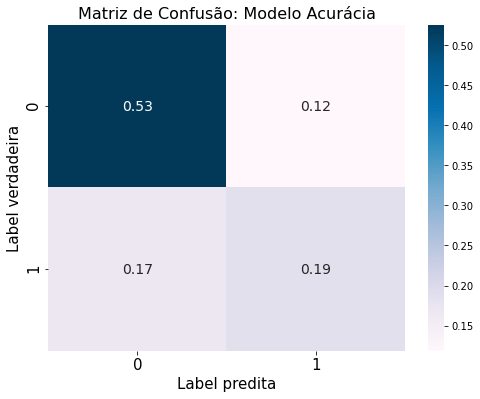

In [14]:
plot_confusion_matrix_params(data = main_split, model = m1_eval, title = "Acurácia")

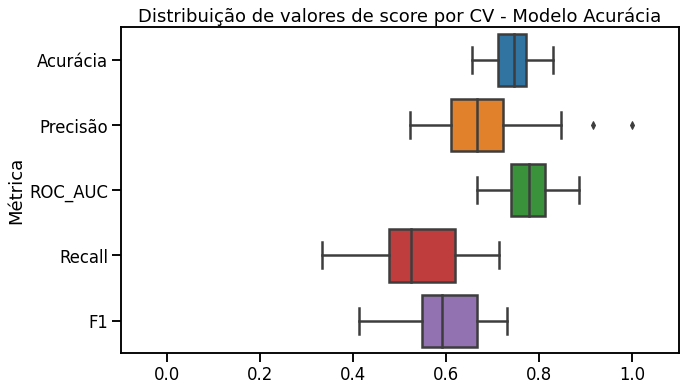

In [15]:
m1_scores = multi_score_cv(model = m1, x = x, y = y, cv = cv,
                           title = "Acurácia")

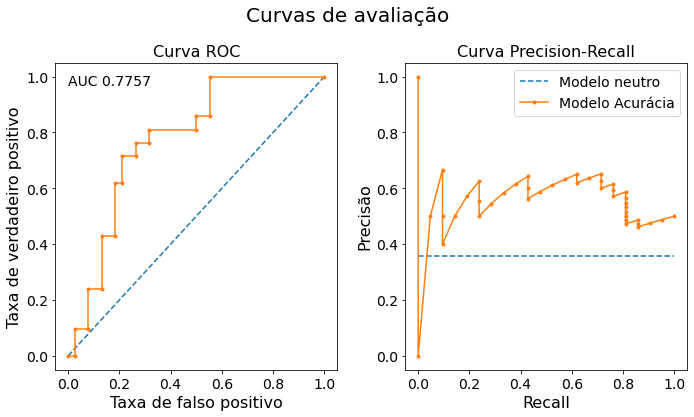

In [16]:
plot_eval_curves(data = main_split, model = m1_eval, title = "Acurácia")

Precisão

In [17]:
m2 = RandomForestClassifier(bootstrap=True, criterion="gini", 
                            max_features=0.1, min_samples_leaf=15, min_samples_split=9, n_estimators=100)

In [18]:
m2_eval = m1.fit(X = main_split[0], y = main_split[2])

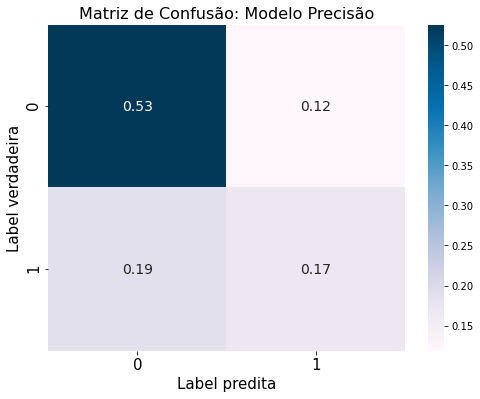

In [19]:
plot_confusion_matrix_params(data = main_split, model = m2_eval, title = "Precisão")

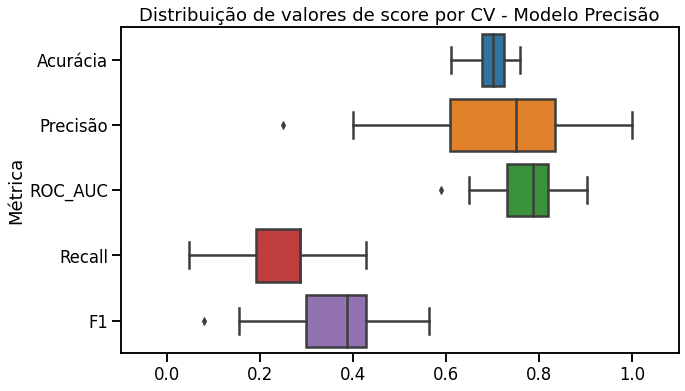

In [20]:
m2_scores = multi_score_cv(model = m2, x = x, y = y, cv = cv,
                           title = "Precisão")

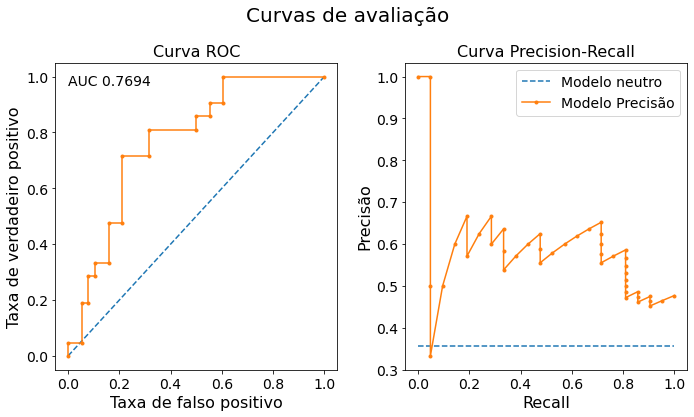

In [21]:
plot_eval_curves(data = main_split, model = m2_eval, title = "Precisão")

ROC

In [22]:
m3 = make_pipeline(
    SelectPercentile(score_func=f_classif, percentile=60),
    RandomForestClassifier(bootstrap=True, criterion="gini", max_features=0.1, 
                           min_samples_leaf=18, min_samples_split=9, n_estimators=100)
)

In [23]:
m3_eval = m3.fit(X = main_split[0], y = main_split[2])

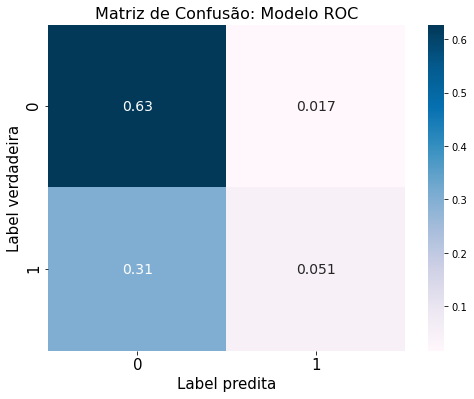

In [24]:
plot_confusion_matrix_params(data = main_split, model = m3_eval, title = "ROC")

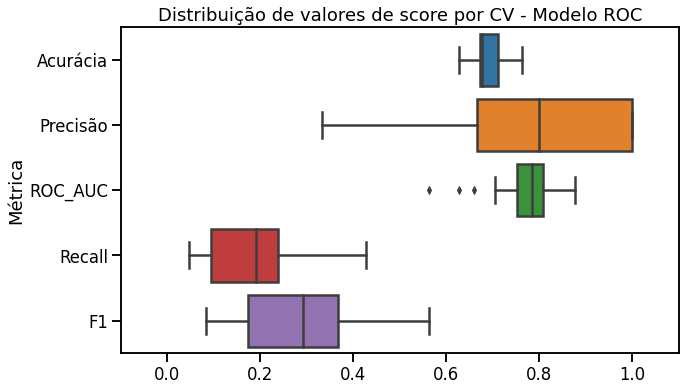

In [25]:
m3_scores = multi_score_cv(model = m3, x = x, y = y, cv = cv,
                           title = "ROC")

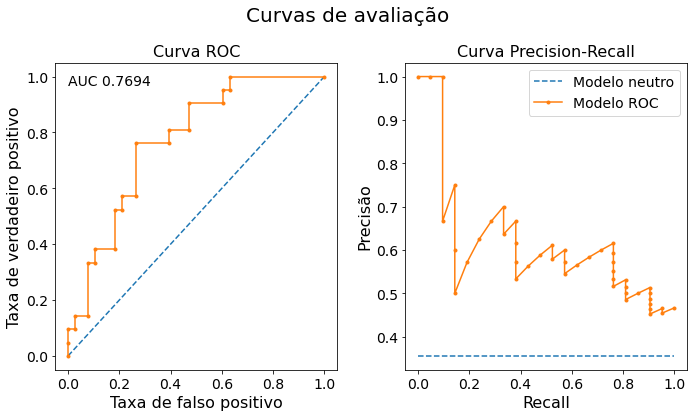

In [26]:
plot_eval_curves(data = main_split, model = m3_eval, title = "ROC")

RECALL

In [27]:
m4 = make_pipeline(
    StackingEstimator(estimator=RandomForestClassifier(bootstrap=True, criterion="gini",
     max_features=0.05, min_samples_leaf=2, min_samples_split=14, n_estimators=100)),
    StandardScaler(),
    SelectFwe(score_func=f_classif, alpha=0.02),
    BernoulliNB(alpha=0.001, fit_prior=False)
)

In [28]:
m4_eval = m4.fit(X = main_split[0], y = main_split[2])

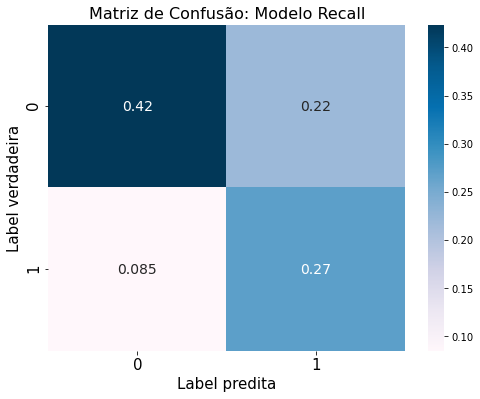

In [29]:
plot_confusion_matrix_params(data = main_split, model = m4_eval, title = "Recall")

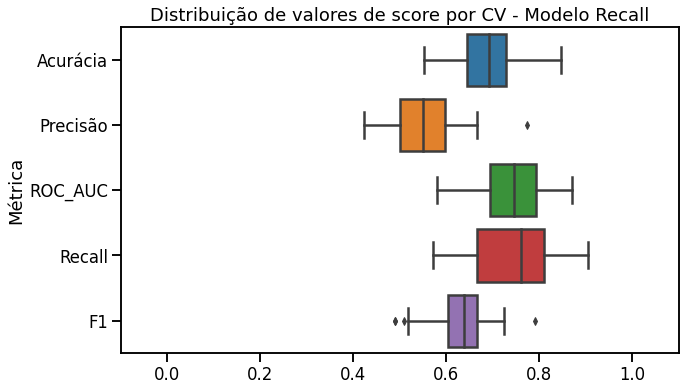

In [30]:
m4_scores = multi_score_cv(model = m4, x = x, y = y, cv = cv,
                           title = "Recall")

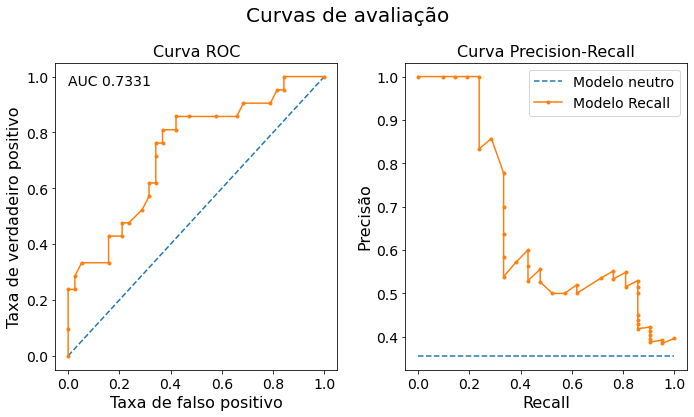

In [31]:
plot_eval_curves(data = main_split, model = m4_eval, title = "Recall")

F1

In [32]:
m5 = make_pipeline(
    ZeroCount(),
    RandomForestClassifier(bootstrap=True, criterion="gini", max_features=0.7500000000000001, min_samples_leaf=15, min_samples_split=13, n_estimators=100)
)

In [33]:
m5_eval = m5.fit(X = main_split[0], y = main_split[2])

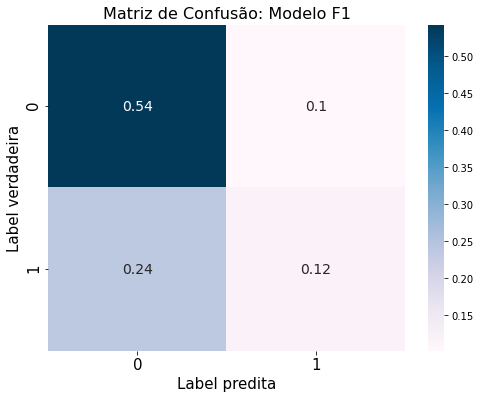

In [34]:
plot_confusion_matrix_params(data = main_split, model = m5_eval, title = "F1")

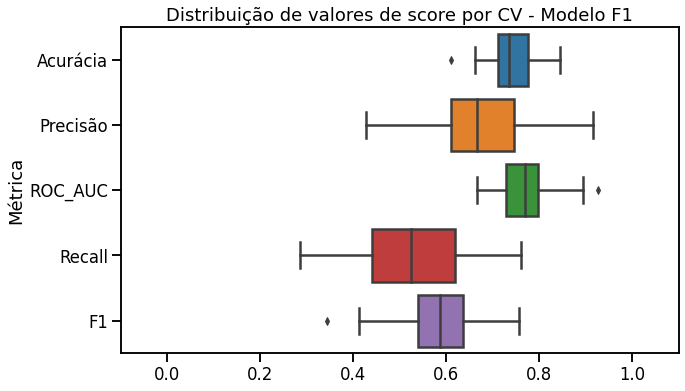

In [35]:
m5_scores = multi_score_cv(model = m5, x = x, y = y, cv = cv,
                           title = "F1")

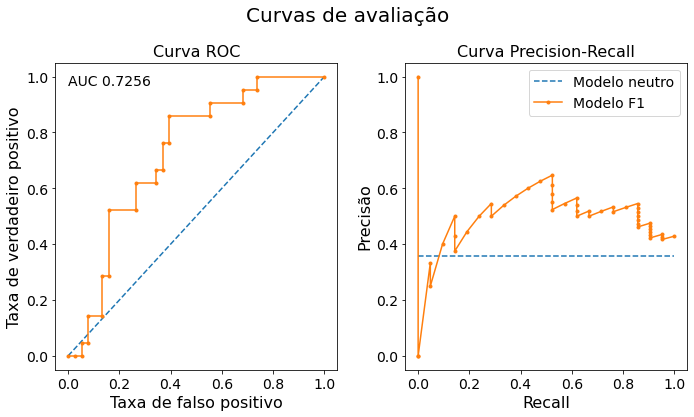

In [36]:
plot_eval_curves(data = main_split, model = m5_eval, title = "F1")